Reference
- https://nlp.seas.harvard.edu/2018/04/03/attention.html

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import sentencepiece as spm
from modeling.transformer import *
from dataset import load_dataset
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
import glob

In [3]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [4]:
sent_pairs = load_dataset()

Exception: 187th sentence of /home/jkfirst/workspace/git/LaH/dataset/Corpus10/cekcorpus31.txt: 'cp949' codec can't decode byte 0xc9 in position 7412: illegal multibyte sequence
>> 61106 sentence pairs loaded
>> 62106 sentence pairs loaded


In [5]:
def remove_bos_eos(pair):
    src, trg = pair
    src = re.sub('<start> ', '', src)
    src = re.sub(' <end>', '', src)
    trg = re.sub('<start> ', '', trg)
    trg = re.sub(' <end>', '', trg)
    return [src, trg]

In [6]:
sent_pairs = list(map(lambda x: remove_bos_eos(x), sent_pairs))

In [7]:

with open('./spm_src.txt', 'w', encoding='utf8') as src_f:
    for sp in sent_pairs:
        src_f.write(sp[0] + '\n')

with open('./spm_trg.txt', 'w', encoding='utf8') as trg_f:
    for sp in sent_pairs:
        trg_f.write(sp[1] + '\n')

In [8]:
templates= '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'

In [9]:
src_input_file = "./spm_src.txt"
pad_id=0  #<pad> token을 0으로 설정
vocab_size = 10000 # vocab 사이즈
src_prefix = 'spm-src-{}'.format(vocab_size) # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='unigram' # Choose from unigram (default), bpe, char, or word

trg_input_file = "./spm_trg.txt"
pad_id=0  #<pad> token을 0으로 설정
vocab_size = 10000 # vocab 사이즈
trg_prefix = 'spm-trg-{}'.format(vocab_size) # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='unigram' # Choose from unigram (default), bpe, char, or word

In [10]:
make_sentencepiece = True

In [11]:
src_cmd = templates.format(src_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                src_prefix,
                vocab_size,
                character_coverage,
                model_type)

In [12]:
trg_cmd = templates.format(trg_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                trg_prefix,
                vocab_size,
                character_coverage,
                model_type)

In [13]:
if make_sentencepiece:
    src_spm = spm.SentencePieceTrainer.Train(src_cmd)
    trg_spm = spm.SentencePieceTrainer.Train(trg_cmd)
    src_spm = spm.SentencePieceProcessor()
    trg_spm = spm.SentencePieceProcessor()
    src_spm.Load('{}.model'.format(src_prefix)) 
    trg_spm.Load('{}.model'.format(trg_prefix))
else: 
    src_spm = spm.SentencePieceProcessor()
    trg_spm = spm.SentencePieceProcessor()
    src_spm.Load('{}.model'.format(src_prefix)) 
    trg_spm.Load('{}.model'.format(trg_prefix)) 

In [14]:
extra_options = 'bos:eos' #'reverse:bos:eos'
src_spm.SetEncodeExtraOptions(extra_options)
trg_spm.SetEncodeExtraOptions(extra_options)

True

In [15]:
kor, eng = sent_pairs[100]
kor = re.sub('<start> ', '', kor)
kor = re.sub(' <end>', '', kor)
eng = re.sub('<start> ', '', eng)
eng = re.sub(' <end>', '', eng)
kor , eng

('너 자신의 방법으로 해 나가라', 'do it your own way')

In [16]:
tokens = src_spm.EncodeAsPieces(kor)
indice = src_spm.EncodeAsIds(kor)
tokens, indice

(['<s>', '▁너', '▁자신', '의', '▁방법으로', '▁해', '▁나', '가', '라', '</s>'],
 [1, 37, 148, 6, 2800, 175, 29, 11, 117, 2])

In [17]:
tokens = trg_spm.EncodeAsPieces(eng)
indice = trg_spm.EncodeAsIds(eng)
tokens, indice

(['<s>', '▁do', '▁it', '▁your', '▁own', '▁way', '</s>'],
 [1, 52, 20, 32, 278, 146, 2])

In [18]:
# class Batch:
#     "Object for holding a batch of data with mask during training."
#     def __init__(self, src, trg=None, pad=0):
#         self.src = src
#         self.src_mask = (src != pad).unsqueeze(-2)
#         if trg is not None:
#             self.trg = trg[:, :-1]
#             self.trg_y = trg[:, 1:]
#             self.trg_mask = \
#                 self.make_std_mask(self.trg, pad)
#             self.ntokens = (self.trg_y != pad).data.sum()
    
#     @staticmethod
#     def make_std_mask(tgt, pad):
#         "Create a mask to hide padding and future words."
#         tgt_mask = (tgt != pad).unsqueeze(-2)
#         tgt_mask = tgt_mask & Variable(
#             subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
#         return tgt_mask

In [19]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
#     for i in range(nbatches):
#         data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
#         data[:, 0] = 1
#         src = Variable(data, requires_grad=False)
#         tgt = Variable(data, requires_grad=False)
#         yield Batch(src, tgt, 0)
    for sp in sent_pairs:
        src, trg = sp
        inp_tensor = torch.LongTensor(src_spm.EncodeAsIds(src)).unsqueeze(dim=0)
        out_tensor = torch.LongTensor(trg_spm.EncodeAsIds(trg)).unsqueeze(dim=0)
        src_token = Variable(inp_tensor, requires_grad=False)
        trg_token = Variable(out_tensor, requires_grad=False)
        dataset = TensorDataset(Batch(src_token, trg_token))
        yield dataset

In [20]:
# data_gen(11, 2, 3)

In [21]:
def set_padding(dataset_list):
    # to list
    src_token_list = [ds[0] for ds in dataset_list]
    trg_token_list = [ds[1] for ds in dataset_list]
    src_mask_list = [ds[2] for ds in dataset_list]
    trg_mask_list = [ds[3] for ds in dataset_list]
    ntokens = sum([ds[4] for ds in dataset_list])
    
    # padding
    src_token_tensor = pad_sequence(src_token_list, batch_first=True)
    trg_token_tensor = pad_sequence(trg_token_list, batch_first=True)
    src_mask_tensor = pad_sequence(src_mask_list, batch_first=True).unsqueeze(dim=-2)
    trg_mask_tensor = pad_sequence(trg_mask_list, batch_first=True).unsqueeze(dim=-2)
    
    return [src_token_tensor, trg_token_tensor, src_mask_tensor, trg_mask_tensor, ntokens]

In [22]:
class TranslationDataset(Dataset):
    def __init__(self, sent_pairs):
        self.dataset = sent_pairs
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        src, trg = self.dataset[idx]
        
        # to Tensor
        inp_tensor = torch.LongTensor(src_spm.EncodeAsIds(src))#.unsqueeze(dim=0)
        out_tensor = torch.LongTensor(trg_spm.EncodeAsIds(trg))#.unsqueeze(dim=0)
        src_mask = (inp_tensor != src_spm.pad_id()).int()
        trg_mask = (out_tensor != trg_spm.pad_id()).int()
        ntokens = (out_tensor != trg_spm.pad_id()).data.sum()
        
        # to Variable
        src_token = Variable(inp_tensor, requires_grad=False)
        trg_token = Variable(out_tensor, requires_grad=False)
        src_mask = Variable(src_mask, requires_grad=False)
        trg_mask = Variable(trg_mask, requires_grad=False)
        
        return [src_token, trg_token, src_mask, trg_mask, ntokens]

In [23]:
dataset = TranslationDataset(sent_pairs)

In [24]:
dataloader = DataLoader(dataset, batch_size=5, collate_fn=set_padding)

```python
>>> for i, batch in enumerate(dataloader):
>>>     if i > 3:
>>>         break
>>>     print(i, batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape)
```

```
0 torch.Size([5, 10]) torch.Size([5, 9]) torch.Size([5, 10]) torch.Size([5, 9])
1 torch.Size([5, 8]) torch.Size([5, 9]) torch.Size([5, 8]) torch.Size([5, 9])
2 torch.Size([5, 11]) torch.Size([5, 10]) torch.Size([5, 11]) torch.Size([5, 10])
3 torch.Size([5, 9]) torch.Size([5, 8]) torch.Size([5, 9]) torch.Size([5, 8])
```

In [25]:
for i, batch in enumerate(dataloader):
    if i > 3:
        break
    print(i, batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape)

0 torch.Size([5, 10]) torch.Size([5, 9]) torch.Size([5, 1, 10]) torch.Size([5, 1, 9])
1 torch.Size([5, 8]) torch.Size([5, 9]) torch.Size([5, 1, 8]) torch.Size([5, 1, 9])
2 torch.Size([5, 11]) torch.Size([5, 10]) torch.Size([5, 1, 11]) torch.Size([5, 1, 10])
3 torch.Size([5, 9]) torch.Size([5, 8]) torch.Size([5, 1, 9]) torch.Size([5, 1, 8])


In [26]:
#def run_epoch(dataloader)
def run_epoch(dataloader, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(dataloader):
        batch_src, batch_trg, batch_src_mask, batch_trg_mask, batch_ntokens = batch
        #'''
        out = model.forward(batch_src, batch_trg, batch_src_mask, batch_trg_mask)
        loss = loss_compute(out, batch_trg, batch_ntokens)
        total_loss += loss
        total_tokens += batch_ntokens
        tokens += batch_ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch_ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
        #'''
    return total_loss / total_tokens

In [27]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [28]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

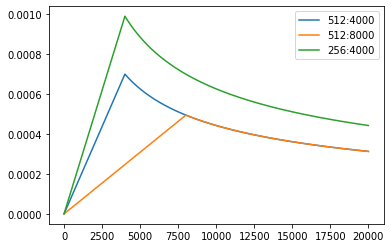

In [29]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [30]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/home/jkfirst/workspace/git/LaH/env/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


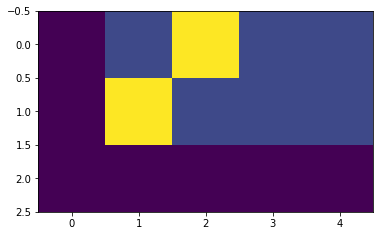

In [31]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

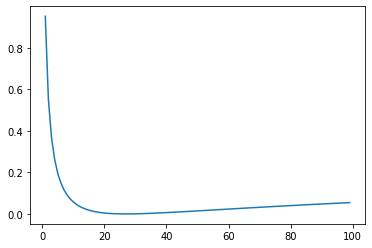

In [32]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    c = crit(Variable(predict.log()), Variable(torch.LongTensor([1])))
    return c.data.item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [33]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

In [34]:
# Train the simple copy task.
V = 10000
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

/home/jkfirst/workspace/git/LaH/env/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/jkfirst/workspace/git/LaH/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [35]:
for epoch in range(10):
    model.train()
    run_epoch(dataloader, model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    break
    #model.eval()
    #print(run_epoch(data_gen(V, 30, 5), model, 
    #                SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 9.236407 Tokens per Sec: 92.012199
Epoch Step: 51 Loss: 6.661267 Tokens per Sec: 104.818481
Epoch Step: 101 Loss: 5.460552 Tokens per Sec: 106.896980
Epoch Step: 151 Loss: 4.445307 Tokens per Sec: 104.183876
Epoch Step: 201 Loss: 5.088363 Tokens per Sec: 111.045815
Epoch Step: 251 Loss: 5.522360 Tokens per Sec: 154.245819
Epoch Step: 301 Loss: 5.200480 Tokens per Sec: 152.021515
Epoch Step: 351 Loss: 4.470091 Tokens per Sec: 142.346436
Epoch Step: 401 Loss: 3.513521 Tokens per Sec: 129.800110
Epoch Step: 451 Loss: 4.830554 Tokens per Sec: 100.446251
Epoch Step: 501 Loss: 3.620784 Tokens per Sec: 89.733421
Epoch Step: 551 Loss: 3.962480 Tokens per Sec: 90.463333
Epoch Step: 601 Loss: 4.881327 Tokens per Sec: 92.992744
Epoch Step: 651 Loss: 3.826474 Tokens per Sec: 101.211586
Epoch Step: 701 Loss: 3.672492 Tokens per Sec: 104.364899
Epoch Step: 751 Loss: 4.272777 Tokens per Sec: 112.081589
Epoch Step: 801 Loss: 5.219074 Tokens per Sec: 113.504883
Epoch Step: 851 Loss:

KeyboardInterrupt: 


### make data generator

In [46]:
from dataset import load_dataset

In [47]:
sent_pairs = load_dataset()

Exception: 187th sentence of /home/jkfirst/workspace/git/LaH/dataset/Corpus10/cekcorpus31.txt: 'cp949' codec can't decode byte 0xc9 in position 7412: illegal multibyte sequence
>> 61106 sentence pairs loaded
>> 62106 sentence pairs loaded


In [48]:
sent_pairs[0]

['<start> 음악이 퍼져 나오기 시작했다 <end>', '<start> the music began to play <end>']

In [74]:
def sentence_pair_gen(sent_pairs):
    for pair in sent_pairs:
        yield TranslationText(kr=pair[0], en=pair[1])

In [63]:
from transformers import BertTokenizer
from kogpt2.utils import get_tokenizer
from gluonnlp.data import SentencepieceTokenizer
from kogpt2.pytorch_kogpt2 import get_pytorch_kogpt2_model
from torch.utils.data import Dataset, DataLoader

In [56]:
model_nm = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_nm)
eng_tokenizer = tokenizer.tokenize

embedding_size = 10
hidden_size = 32
n_batch = 8

In [59]:
tok_path = get_tokenizer()
kor_tokenizer = SentencepieceTokenizer(tok_path)
_, vocab = get_pytorch_kogpt2_model()

using cached model
using cached model
using cached model


In [60]:
def convert_string_to_index(kr=None, en=None, kr_pad=tokenizer.vocab['[PAD]'], en_pad=vocab(['<pad>'])[0], maxlen=50):
    '''
        convert korean/english sentence into its own indices.
        maximum length of converted indices is `maxlen`
    '''
    assert (kr != None) or (en != None), 'one of either kr or en should have a value'
    kr_index, en_index = None, None
    
    if kr:
        kr_index = vocab(kor_tokenizer(kr))
        if len(kr_index) > maxlen:
            kr_index = kr_index[:maxlen]
        else:
            kr_index = kr_index + [kr_pad] * (maxlen-len(kr_index))
    if en:
        en_index = tokenizer.convert_tokens_to_ids(eng_tokenizer(en))
        if len(en_index) > maxlen:
            en_index = en_index[:maxlen]
        else:
            en_index = en_index + [en_pad] * (maxlen-len(en_index))
        
    return kr_index, en_index

In [61]:
class TranslationText():
    def __init__(self, kr, en):
        self.kr = kr
        self.en = en

In [82]:
class TranslationDataset(Dataset):
    """Translation dataset."""

    def __init__(self, sent_pairs, transform=None, names=['kor', 'eng'], sep='\t'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            names (list): A list of column names
            sep (string): A string that is used for a delimiter.
        """
        self.sengen = sentence_pair_gen(sent_pairs)
        self.transform = transform

    def __len__(self):
        return len(sent_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        onerow =  next(self.sengen)
        kr_index, en_index = convert_string_to_index(kr=onerow.kr, en=onerow.en)
        kor_tensor = torch.LongTensor(kr_index)
        eng_tensor = torch.LongTensor(en_index)
        return (kor_tensor, eng_tensor)

In [83]:
dataset = TranslationDataset(sent_pairs)

In [84]:
dataset[0]

(tensor([  964, 39786, 47914, 29492, 16719, 25915,  2813,   964,  6339, 47914,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1026, 2707, 1028, 1996, 2189, 2211, 2000, 2377, 1026, 2203, 1028,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3]))